<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2023-2/Exemplos_AE/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-encoder para limpar ruído

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import keras

from keras.models import Model
from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, UpSampling2D

print(keras.__version__)

2.14.0


In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# normalize train data
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
print(x_train.shape)

(60000, 28, 28, 1)


In [5]:
# normalize test data (which serves as our labels)
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_test.shape)

(10000, 28, 28, 1)


In [6]:
# create noisy data for train and test
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [7]:
# renormalize through clipping
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [21]:
# create the encode network
input_img = Input(shape=(28,28,1))
x = Convolution2D(32,(3,3),activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2),padding='same')(x)
x = Convolution2D(32,(3,3),activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)
# 7,7,32

In [22]:
# create the decode network
x = Convolution2D(32,(3,3),activation='relu',padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Convolution2D(32,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Convolution2D(1,(3,3),activation='sigmoid',padding='same')(x)
#back to 28,28,1

In [23]:
# create the autoencoder by tying the encode and decode networks together
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 32)          9248

In [24]:
# train
autoencoder.fit(x_train_noisy, x_train,
  epochs=10,
  batch_size=256,
  shuffle=True,
  validation_data=(x_test_noisy, x_test))

Epoch 1/10
235/235 [==============================] - 14s 13ms/step - loss: 0.2110 - val_loss: 0.1261
Epoch 2/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1212 - val_loss: 0.1154
Epoch 3/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1143 - val_loss: 0.1109
Epoch 4/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1105 - val_loss: 0.1082
Epoch 5/10
235/235 [==============================] - 3s 12ms/step - loss: 0.1079 - val_loss: 0.1057
Epoch 6/10
235/235 [==============================] - 2s 10ms/step - loss: 0.1061 - val_loss: 0.1046
Epoch 7/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1047 - val_loss: 0.1031
Epoch 8/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1036 - val_loss: 0.1031
Epoch 9/10
235/235 [==============================] - 3s 12ms/step - loss: 0.1027 - val_loss: 0.1018
Epoch 10/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1020 - val_l

In [27]:
# create the encoder model
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
Total params: 9568 (37.38 KB)
Trainable params: 9568 (37.38

In [29]:
# create the decoder model
encoded_input = Input(shape=(7,7,32))

# this is pretty ugly. is there a better way? like layer.pop?
decoder1 = autoencoder.layers[-5]
decoder2 = autoencoder.layers[-4]
decoder3 = autoencoder.layers[-3]
decoder4 = autoencoder.layers[-2]
decoder5 = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder5(decoder4(decoder3(decoder2(decoder1(encoded_input))))))
decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 7, 32)]        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 32)          9248      
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 1)         289 

In [30]:
# run noisy test data through the encoder
encoded_imgs = encoder.predict(x_test_noisy)

# run encoded noisy test image back through the decoder
decoded_imgs = decoder.predict(encoded_imgs)

# make sense of the shapes
print(encoded_imgs.shape)
print(decoded_imgs.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 7, 7, 32)
(10000, 28, 28, 1)


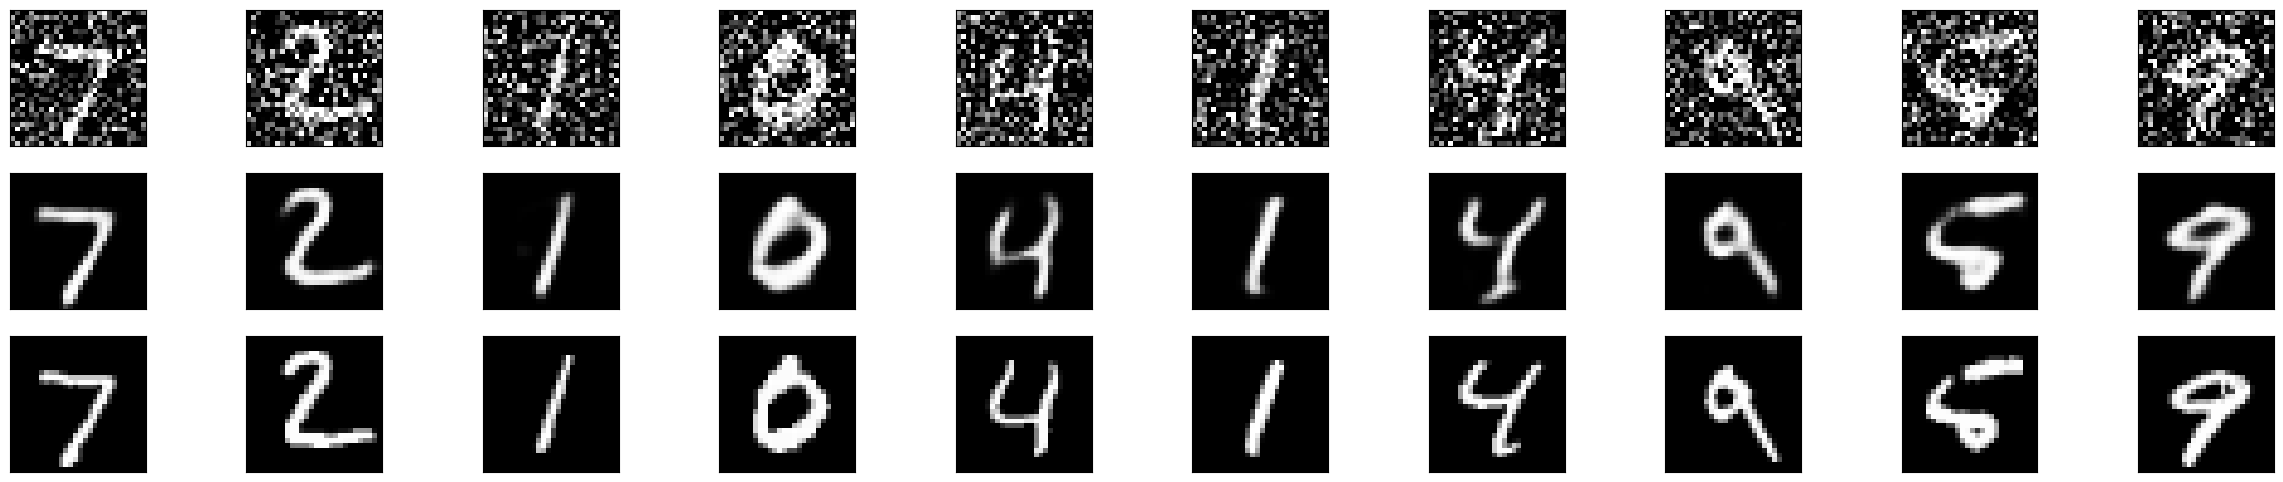

In [31]:
# display the images
n = 10
plt.figure(figsize=(30,6))
for i in range(n):
  # noisy images
  ax = plt.subplot(3,n,i+1)
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # denoised images
  ax = plt.subplot(3,n,i+1+n)
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # original images
  ax = plt.subplot(3,n,i+1+n*2)
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()